In [3]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd

# Compute the standard error in two ways: (1) statsmodels OLS, (2) simulation

OLS estimate: 0.03103376236729251
Mean effect estimate: 1.499180865864717
Standard deviation of effect: 0.03148056946207219


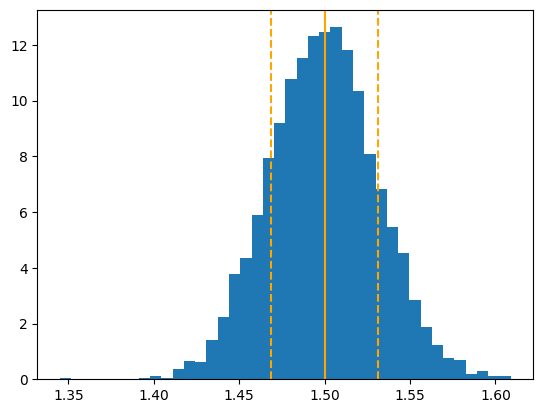

In [93]:
def compute_standard_error(effect, sigma_x, sigma_resid, sample_size, n_sims = 1000, random_seed = 0):
    np.random.seed(random_seed)

    X = np.random.normal(0, sigma_x, sample_size)
    Y = 2 + effect * X + np.random.normal(0, sigma_resid, sample_size)
    df = sm.add_constant(pd.DataFrame({"X": X}))
    results = sm.OLS(Y, df).fit()
    print("OLS estimate:", results.bse.X)

    effect_list = list()
    for _ in range(n_sims):
        X = np.random.normal(0, sigma_x, sample_size)
        Y = 2 + effect * X + np.random.normal(0, sigma_resid, sample_size)
        df = sm.add_constant(pd.DataFrame({"X": X}))
        results = sm.OLS(Y, df).fit()
        effect_list.append(results.params.X)
    print("Mean effect estimate:", np.mean(effect_list))
    print("Standard deviation of effect:", np.std(effect_list))

    plt.hist(effect_list, density = True, bins = 40)
    plt.axvline(effect, color = 'orange')
    plt.axvline(effect + np.std(effect_list), color = 'orange', linestyle = '--')
    plt.axvline(effect - np.std(effect_list), color = 'orange', linestyle = '--')

compute_standard_error(1.5, 1, 1, 1000, 3000, 0)

### True effect, Var(X), Var(Resid), sample size

0.03103376236729252
0.031599487598520874


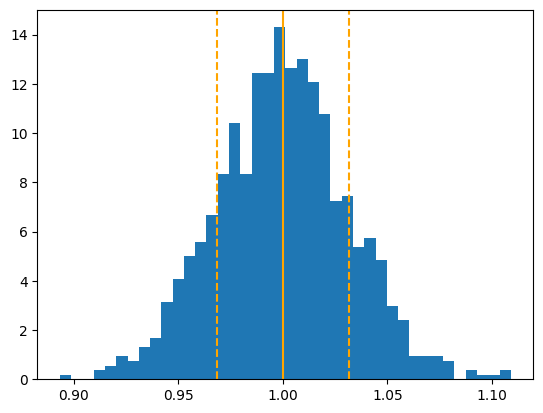

In [16]:
def compute_standard_error(true_effect, var_x, var_resid, sample_size, n_sims = 1000, random_seed = 0):
    np.random.seed(random_seed)

    X = np.random.normal(0, np.sqrt(var_x), sample_size)
    Y = 1 + true_effect * X + np.random.normal(0, np.sqrt(var_resid), sample_size)
    df = sm.add_constant(pd.DataFrame({"X": X}))
    results = sm.OLS(Y, df).fit()
    print(results.bse.X)

    params_list = list()
    for _ in range(n_sims):
        X = np.random.normal(0, np.sqrt(var_x), sample_size)
        Y = 1 + true_effect * X + np.random.normal(0, np.sqrt(var_resid), sample_size)
        df = sm.add_constant(pd.DataFrame({"X": X})) 
        results = sm.OLS(Y, df).fit()
        params_list.append(results.params.X)
    print(np.std(params_list))

    plt.hist(params_list, density = True, bins = 40)
    plt.axvline(true_effect, color = 'orange')
    plt.axvline(true_effect + np.std(params_list), color = 'orange', label = '+1 SE', linestyle = '--')
    plt.axvline(true_effect - np.std(params_list), color = 'orange', label = '-1 SE', linestyle = '--')

compute_standard_error(1, 1, 1, 1000)

# Compute statistical power

In [119]:
def compute_power(effect, sigma_x, sigma_resid, num_samples, n_sim = 1000, random_seed = 0):
    np.random.seed(random_seed)
    critical_t = 1.96

    detections = 0
    
    for _ in range(n_sim):
        X = np.random.normal(0, sigma_x, size=num_samples)
        Y = effect * X + np.random.normal(0, sigma_resid, size=num_samples)
        df = sm.add_constant(pd.DataFrame({"X": X}))
        results = sm.OLS(Y, df).fit()
        if np.abs(results.tvalues.X) > critical_t:
            detections += 1

    return detections / n_sim

compute_power(1, 1, 1, 10, 10000, 0)

0.7831

In [117]:
def compute_power(true_effect, sigma_x, sigma_resid, num, n_sim=10000, random_seed=0):
    np.random.seed(random_seed)
    critical_t = 1.96

    detections = 0

    for _ in range(n_sim):
        X = np.random.normal(0, sigma_x, size=num)
        Y = true_effect * X + np.random.normal(0, sigma_resid, size=num)
        df = sm.add_constant(pd.DataFrame({"X": X}))
        results = sm.OLS(Y, df).fit()
        t_value = results.tvalues.X
        if np.abs(t_value) > critical_t:
            detections += 1

    power = detections / n_sim
    return power

power = compute_power(true_effect=0.5, sigma_x=1.0, sigma_resid=1.0, num=10, n_sim=10000)

print(f"Estimated Statistical Power: {power:.4f}")

Estimated Statistical Power: 0.3577


In [111]:
10 * np.exp(np.linspace(0, np.log(1000 / 10), num = 10))

array([  10.        ,   16.68100537,   27.82559402,   46.41588834,
         77.42636827,  129.1549665 ,  215.443469  ,  359.38136638,
        599.48425032, 1000.        ])

In [120]:
def sample_size_for_power(min_sample_size, max_sample_size, num_size):
    sizes = [int(x) for x in min_sample_size * np.exp(np.linspace(0, np.log(max_sample_size / min_sample_size), num = num_size))]

    power_list = list()
    for size in sizes:
        power_list.append(compute_power(1, 1, 1, size, 1000, 0))

    print(list(zip(power_list, sizes)))

sample_size_for_power(10, 1000, 10)

[(0.776, 10), (0.931, 16), (0.995, 27), (1.0, 46), (1.0, 77), (1.0, 129), (1.0, 215), (1.0, 359), (1.0, 599), (1.0, 1000)]


# Sample size for power

In [58]:
def sample_size_for_power(min_sample_size, max_sample_size, num_sizes):
    sizes = min_sample_size * np.exp(np.linspace(0, np.log(max_sample_size / min_sample_size), num = num_sizes))
    sizes = [int(np.around(x)) for x in sizes]
    size_list = list()
    for size in sizes:
        power = compute_power(0.5, 1, 1, size, 1000, 0)
        size_list.append(power)
    return size_list

sample_size_for_power(10, 1000, 10)

[0.341, 0.535, 0.714, 0.895, 0.995, 1.0, 1.0, 1.0, 1.0, 1.0]

# Binary search for sample size for power

In [72]:
def binary_search_for_sample_size(min_sample_size, max_sample_size, goal_power):
    average_sample_size = int((min_sample_size + max_sample_size) / 2)
    computed_power = compute_power(0.5, 1, 2, average_sample_size, 1000, 0)
    # print(min_sample_size, max_sample_size, computed_power)
    if min_sample_size == max_sample_size:
        return computed_power, average_sample_size
    if computed_power >= goal_power:
        return binary_search_for_sample_size(min_sample_size, average_sample_size, goal_power)
    if computed_power < goal_power:
        return binary_search_for_sample_size(average_sample_size + 1, max_sample_size, goal_power)

binary_search_for_sample_size(10, 1000, 0.8)

(0.832, 67)

# Find sample size for power

In [77]:
def compute_power(true_effect, sigma_x, sigma_eps, num, n_sim=100, random_seed=42):
    np.random.seed(random_seed)
    critical_t = 1.96
    detections = 0

    for _ in range(n_sim):
        X = np.random.normal(0, sigma_x, size=num)
        Y = true_effect * X + np.random.normal(0, sigma_eps, size=num)
        df = sm.add_constant(pd.DataFrame({"X": X}))
        results = sm.OLS(Y, df).fit()
        t_value = results.tvalues.X
        if abs(t_value) > critical_t:
            detections += 1

    return detections / n_sim

def binary_search_for_power(min_size = 10, max_size = 1000, power_goal = 0.8):
    average_size = int((min_size + max_size) / 2)    
    power = compute_power(1, 1, 1, average_size, n_sim=100, random_seed = 0)
    if min_size == max_size:
        return power, average_size
    if power > power_goal:
        return binary_search_for_power(min_size, average_size, power_goal)
    elif power < power_goal:
        return binary_search_for_power(average_size + 1, max_size, power_goal)
    else: # power == power_goal
        return power, average_size

binary_search_for_power(10, 1000, 0.99)

(0.99, 28)